<a href="https://colab.research.google.com/github/ljs2021/Machine-Learning-Book-/blob/master/8%EC%A3%BC%EC%B0%A8_%EB%B6%84%EB%A5%98_%EC%8B%A4%EC%8A%B5(XGBoost%2CLightGBM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 분류 실습 - 캐글 산탄데르 고객 만족 예측

> 370개의 피처로 주언진 데이터 세트 기반에서 고객 만족 여부를 예측하는 것. 1:불만족 , 0:만족 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/santander-customer-satisfaction/train_santander.csv",encoding='latin-1')
print('dataset shape:',cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.0,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [3]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [8]:
print(cust_df['TARGET'].value_counts())
unsatisifed_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print("불만족 비율 {:.2f}".format(unsatisifed_cnt/total_cnt))

0    73012
1     3008
Name: TARGET, dtype: int64
불만족 비율 0.04


In [9]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.0,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.477676,0.011458,0.003762,0.0,0.0,0.958024,0.663760,0.000105,0.000026,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.010168,0.009997,0.000026,0.000026,0.050855,...,1077.256756,1048.856447,68.275452,9.505287,124.620962,110.026575,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,0.175324,0.0,0.513023,0.344174,9.117181e+01,3.646318e+01,1.310316e+02,1.092169e+02,0.213071,0.001910,0.253907,0.186630,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,512.154823,531.897917,950.086398,697.712596,535.473750,953.578624,712.767240,465.391149,0.106425,0.061221,0.0,0.0,0.200535,0.472425,0.010258,0.005129,0.178202,0.166674,0.250925,0.208316,0.222531,0.202714,0.199390,0.100325,0.099486,0.005129,0.005129,0.219703,...,9614.906985,8189.948852,1733.838226,519.389157,2205.249804,1935.305713,3.777314e+04,9292.752726,4.620254e+04,3.550718e+04,26359.174223,7182

NaN 이나 특정 예외 값을 -99999변환 했을 것이다. -999999로 하면 편차가 심하므로 2로 대체 하고 id피처를 드롭한다. 

In [12]:
print(cust_df.var3.value_counts()[:10])
#-999999가 116개 있다는 것을 알 수 있다. 

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64


In [14]:
cust_df['var3'].replace(-999999,2,inplace=True)
cust_df.drop(['ID'],axis=1,inplace=True)

#피처 세트와 레이블 세트 분리.
X_features = cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:,-1]
print("피처 데이터 shape:{}".format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [15]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_features,y_labels,test_size=0.2,random_state=777)

train_cnt = y_train.count()
test_cnt = y_test.count()
print("학습 세트 Shape:{}, 테스트 세트 Shape:{}".format(X_train.shape , X_test.shape))

print("학습 세트 레이블 값 분포 비율 ")
print(y_train.value_counts()/train_cnt)
print("테스트 세트 레이블 값 분포 비율 ")
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율 
0    0.960274
1    0.039726
Name: TARGET, dtype: float64
테스트 세트 레이블 값 분포 비율 
0    0.961063
1    0.038937
Name: TARGET, dtype: float64


**XGBoost 모델 학습과 하이퍼 파라미터 튜닝**

> XGBClassifier를 기반으로 학습 수행. 

n_estimators는 200으로 하되 early_stopping_rounds를 50으로 설정. 성능 평가 기준이 ROC_AUC 이므로 eval_metric는 'auc'라 한다. 

In [17]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

#n_estimator(weak learner의 개수) 500 
xgb_clf = XGBClassifier(n_estimator=500 , random_state=777)

#성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행 

xgb_clf.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='auc',eval_set=[(X_train,y_train),(X_test,y_test)])

xgb_roc_score = roc_auc_score(y_test,xgb_clf.predict_proba(X_test)[:,-1],average='macro')
print("ROC AUC : {:.4f}".format(xgb_roc_score))

[0]	validation_0-auc:0.80314	validation_1-auc:0.79598
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.80478	validation_1-auc:0.797654
[2]	validation_0-auc:0.809073	validation_1-auc:0.8022
[3]	validation_0-auc:0.814523	validation_1-auc:0.806671
[4]	validation_0-auc:0.819113	validation_1-auc:0.810708
[5]	validation_0-auc:0.820157	validation_1-auc:0.813068
[6]	validation_0-auc:0.82028	validation_1-auc:0.812609
[7]	validation_0-auc:0.820059	validation_1-auc:0.812218
[8]	validation_0-auc:0.820543	validation_1-auc:0.81342
[9]	validation_0-auc:0.820313	validation_1-auc:0.813308
[10]	validation_0-auc:0.820087	validation_1-auc:0.812536
[11]	validation_0-auc:0.822033	validation_1-auc:0.815005
[12]	validation_0-auc:0.821414	validation_1-auc:0.813939
[13]	validation_0-auc:0.821522	validation_1-auc:0.813239
[14]	validation_0-auc:0.82593	validation_1-auc:0.816951
[15]	

In [ ]:
from sklearn.model_selection import GridSearchCV

#하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소

xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5,6],"min_child_weight":[1,3],"colsample_bytree":[0.5,0.75]}

#하이퍼 파라미터 테스트의 수행속도를 향상시키기 위해 cv를 지정하지 않음 
gridcv = GridSearchCV(xgb_clf,param_grid=params)
gridcv.fit(X_train,y_train,early_stopping_rounds=30,eval_metric='auc',eval_set=[(X_train,y_train),(X_test,y_test)])

print("GridSearchCV 최적 파라미터 :",gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test,gridcv.predict_proba(X_test)[:,1],average='macro')
print("ROC AUC : {:.4f}".format(xgb_roc_score))

In [21]:
gridcv.predict_proba(X_test)

array([[0.9856535 , 0.01434648],
       [0.9801378 , 0.01986215],
       [0.9522757 , 0.0477243 ],
       ...,
       [0.97877973, 0.02122024],
       [0.97612005, 0.02387997],
       [0.97965026, 0.02034976]], dtype=float32)

**위에서 구한 최적 하이퍼 파라미터를 적용 시킨 뒤 n_estimators=1000으로 증가시키고,learning_rate 0.02로 감소시킨다. reg_alpha 0.03 추가**

In [22]:
# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함. 
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7,\
                        min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# evaluation metric을 auc로, early stopping은 200 으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, 
            eval_metric="auc",eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.825731	validation_1-auc:0.803818
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.828541	validation_1-auc:0.805541
[2]	validation_0-auc:0.83267	validation_1-auc:0.814039
[3]	validation_0-auc:0.836856	validation_1-auc:0.816182
[4]	validation_0-auc:0.837639	validation_1-auc:0.816069
[5]	validation_0-auc:0.839677	validation_1-auc:0.817419
[6]	validation_0-auc:0.840166	validation_1-auc:0.816996
[7]	validation_0-auc:0.84032	validation_1-auc:0.81722
[8]	validation_0-auc:0.840586	validation_1-auc:0.81711
[9]	validation_0-auc:0.84066	validation_1-auc:0.817122
[10]	validation_0-auc:0.842357	validation_1-auc:0.818567
[11]	validation_0-auc:0.841558	validation_1-auc:0.819211
[12]	validation_0-auc:0.842332	validation_1-auc:0.81995
[13]	validation_0-auc:0.842724	validation_1-auc:0.820022
[14]	validation_0-auc:0.844269	validation_1-auc:0.821453
[15

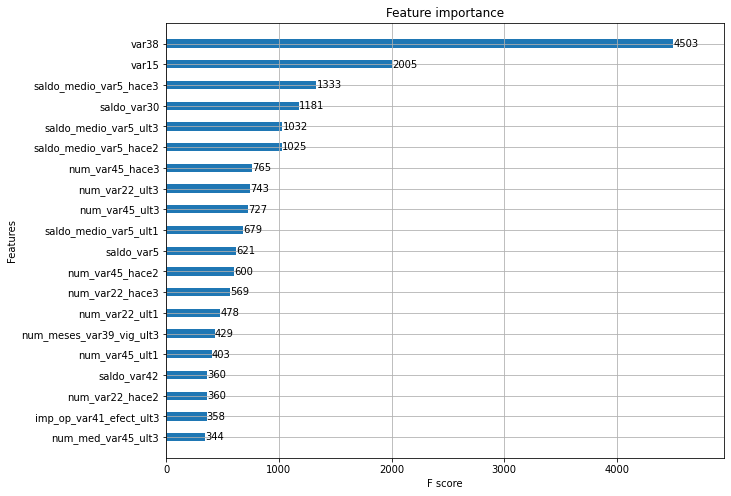

In [23]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

## LightGBM 모델 학습과 하이퍼 파라미터 튜닝

> XGBoost 와 동일 하게 n_estimators 500 early_stopping_rounds 100 평가 데이터 세트는 테스트 데이터 세트 ,eval_metric : auc로 설정 

In [24]:
from lightgbm import LGBMClassifier 

lgbm_clf = LGBMClassifier(n_estimators=500)

evals=[(X_test,y_test)]
lgbm_clf.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='auc',eval_set=evals,verbose=True)

lgbm_roc_score = roc_auc_score(y_test,lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print("ROC AUC: {:.4f}".format(lgbm_roc_score))

[1]	valid_0's auc: 0.805449	valid_0's binary_logloss: 0.156938
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.810916	valid_0's binary_logloss: 0.152223
[3]	valid_0's auc: 0.81241	valid_0's binary_logloss: 0.148938
[4]	valid_0's auc: 0.816366	valid_0's binary_logloss: 0.146523
[5]	valid_0's auc: 0.818686	valid_0's binary_logloss: 0.14442
[6]	valid_0's auc: 0.822203	valid_0's binary_logloss: 0.142805
[7]	valid_0's auc: 0.823735	valid_0's binary_logloss: 0.141453
[8]	valid_0's auc: 0.826469	valid_0's binary_logloss: 0.140333
[9]	valid_0's auc: 0.827418	valid_0's binary_logloss: 0.139361
[10]	valid_0's auc: 0.829474	valid_0's binary_logloss: 0.13856
[11]	valid_0's auc: 0.829281	valid_0's binary_logloss: 0.137947
[12]	valid_0's auc: 0.829776	valid_0's binary_logloss: 0.137411
[13]	valid_0's auc: 0.830078	valid_0's binary_logloss: 0.136986
[14]	valid_0's auc: 0.830672	valid_0's binary_logloss: 0.136517
[15]	valid_0's auc: 0.830755	valid_0's binary_logloss

xgboost와 마찬가지로 GridsearchCV 활용해 하이퍼 파라미터 튜닝 

In [ ]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
LGBM_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves': [32, 64 ],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 1]}


# 하이퍼 파라미터 테스트의 수행속도를 향상 시키기 위해 cv 를 지정하지 않습니다. 
gridcv = GridSearchCV(lgbm_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

In [26]:
#해당 파라미터를 LightGBM에 적용하고 다시 학습해 ROC-AUC 측정 결과 도출 
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, sumbsample=0.8, min_child_samples=100,
                          max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.807683	valid_0's binary_logloss: 0.157167
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.813463	valid_0's binary_logloss: 0.152381
[3]	valid_0's auc: 0.814779	valid_0's binary_logloss: 0.14921
[4]	valid_0's auc: 0.821269	valid_0's binary_logloss: 0.146569
[5]	valid_0's auc: 0.823117	valid_0's binary_logloss: 0.14456
[6]	valid_0's auc: 0.825106	valid_0's binary_logloss: 0.142901
[7]	valid_0's auc: 0.825902	valid_0's binary_logloss: 0.141586
[8]	valid_0's auc: 0.828612	valid_0's binary_logloss: 0.140368
[9]	valid_0's auc: 0.829432	valid_0's binary_logloss: 0.139345
[10]	valid_0's auc: 0.830037	valid_0's binary_logloss: 0.138505
[11]	valid_0's auc: 0.829853	valid_0's binary_logloss: 0.137786
[12]	valid_0's auc: 0.830278	valid_0's binary_logloss: 0.137238
[13]	valid_0's auc: 0.830882	valid_0's binary_logloss: 0.136644
[14]	valid_0's auc: 0.831292	valid_0's binary_logloss: 0.136239
[15]	valid_0's auc: 0.832186	valid_0's binary_loglos